In [ ]:
%%capture
!pip3 install datasets
import datasets
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gensim
from gensim.models import Word2Vec

from transformers import BertModel, AutoTokenizer

# specify GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# I. Data Preparation


## Load the data

In [ ]:
# Load the dataset
ds = load_dataset("google-research-datasets/google_wellformed_query")

# Get test, train, and val datasets
df_train = ds["train"].to_pandas()
print(df_train.shape)

df_test = ds["test"].to_pandas()
print(df_test.shape)

df_val = ds["validation"].to_pandas()
print(df_val.shape)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


google_wellformed_query.py:   0%|          | 0.00/3.24k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.40k [00:00<?, ?B/s]

The repository for google-research-datasets/google_wellformed_query contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/google-research-datasets/google_wellformed_query.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/17500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3850 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3750 [00:00<?, ? examples/s]

(17500, 2)
(3850, 2)
(3750, 2)


## Convert the rating into a binary label

In [ ]:
# Note: The original paper considers a rating >= 0.8 to be well-formed
df_train["rating"] = df_train["rating"].apply(lambda x: 1 if x >= 0.8 else 0)
df_test["rating"] = df_test["rating"].apply(lambda x: 1 if x >= 0.8 else 0)
df_val["rating"] = df_val["rating"].apply(lambda x: 1 if x >= 0.8 else 0)

## Embed the content queries into vectors


In [ ]:
# Function to encodes a sequence/sentence
def bert_encode_sequence(sequence, bert_model, bert_tokenizer):

  # encode the sentence
  encoded = bert_tokenizer.encode_plus(
    text=sequence,
    add_special_tokens=True,  # add [CLS] and [SEP] tokens
    max_length = 30,  # set the maximum length of a sentence
    truncation = True, # truncate longer sentences to max_length
    padding='max_length',  # add [PAD] tokens to shorter sentences
    return_attention_mask = True,  # generate the attention mask (so that no attention is given to padding tokens)
    return_tensors = 'pt',  # return encoding results as PyTorch tensors
  )

  # Each token is assigned an id by the tokenizer
  token_ids = encoded['input_ids']

  # Attention mask is used to ensure that the model does not pay attention to padding tokens
  # Value of mask is 0 if token is a padding token, else 1
  attention_mask = encoded['attention_mask']

  # BERT accepts two sentences at once, so token_type_ids is used to indicate
  # whether each token belongs to sentence A (0) or sentence B (1),
  # but we only have one sentence per query, so all tokens are assigned 0
  token_type_ids = encoded['token_type_ids']

  # set the BERT model in evaluation mode
  bert_model.eval()

  # use device specified above (GPU if available)
  bert_model.to(device)
  token_ids = token_ids.to(device)
  attention_mask = attention_mask.to(device)
  token_type_ids = token_type_ids.to(device)

  # Forward pass through the bert model to get contextual embeddings of each token (without calculating gradients)
  with torch.no_grad():
    # output of shape <batch_size, max_length, embedding_size>
    last_hidden_states = bert_model(token_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)["last_hidden_state"]

  # mean pooled embedding of shape <1, hidden_size>
  mean_pooled_embedding = last_hidden_states.mean(axis=1)

  return mean_pooled_embedding

In [ ]:
# load "bert-base-cased" the pre-trained model
bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = False)

# load the corresponding wordtokenizer
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Apply embeddings to train, test, and val datasets
df_train["embedded_content"] = df_train["content"].apply(lambda x: bert_encode_sequence(x, bert_model, bert_tokenizer))
df_test["embedded_content"] = df_test["content"].apply(lambda x: bert_encode_sequence(x, bert_model, bert_tokenizer))
df_val["embedded_content"] = df_val["content"].apply(lambda x: bert_encode_sequence(x, bert_model, bert_tokenizer))

## Split dataframe into X and y tensors


In [ ]:
# Split the data into X and y
X_train = df_train["embedded_content"]
y_train = df_train["rating"]

X_test = df_test["embedded_content"]
y_test = df_test["rating"]

X_val = df_val["embedded_content"]
y_val = df_val["rating"]

# Move X_train to cpu
X_train = X_train.apply(lambda x: x.cpu().detach().numpy().flatten())
X_test = X_test.apply(lambda x: x.cpu().detach().numpy().flatten())
X_val = X_val.apply(lambda x: x.cpu().detach().numpy().flatten())

X_train_tensor = torch.tensor(np.stack(X_train.values), dtype=torch.float32).squeeze().to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

X_test_tensor = torch.tensor(np.stack(X_test.values), dtype=torch.float32).squeeze().to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

X_val_tensor = torch.tensor(np.stack(X_val.values), dtype=torch.float32).squeeze().to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

# II. Model Training

## Model Definition

In [ ]:
class QueryClassifier(nn.Module):
  def __init__(self, input_size):
    super(QueryClassifier, self).__init__()
    self.hid1 = nn.Sequential(
        nn.Linear(input_size, 100),
        nn.BatchNorm1d(100),
        nn.LeakyReLU()
    )
    self.hid2 = nn.Sequential(
        nn.Linear(100, 50),
        nn.BatchNorm1d(50),
        nn.LeakyReLU()
    )
    self.hid3 = nn.Sequential(
        nn.Linear(50, 25),
        nn.BatchNorm1d(25),
        nn.LeakyReLU()
    )
    self.hid4 = nn.Sequential(
        nn.Linear(25, 10),
        nn.BatchNorm1d(10),
        nn.LeakyReLU()
    )

    self.output = nn.Linear(10, 2)

    # Weight Initialization
    for layer in self.children():
        if isinstance(layer, nn.Linear):
            nn.init.kaiming_uniform_(layer.weight, nonlinearity='leaky_relu')
            nn.init.zeros_(layer.bias)

  def forward(self, x):
    z = self.hid1(x)
    z = self.hid2(z)
    z = self.hid3(z)
    z = self.hid4(z)
    z = torch.softmax(self.output(z), dim=1)
    return z

## Train the model

In [ ]:
def train_one_epoch(model, training_loader, epoch_idx, loss_fn, optimizer):
  running_loss = 0.0
  last_loss = 0.0

  model.train()  # Set the model to training mode

  for i, data in enumerate(training_loader):
    # Every data instance is an input + label pair
    inputs, labels = data

    # Zero gradients for every batch
    optimizer.zero_grad()

    # Make predictions for this batch
    outputs = model(inputs)

    # Compute the loss and its gradients
    loss = loss_fn(outputs, labels)
    loss.backward()

    # Adjust learnable parameters
    optimizer.step()

    # Gather data and report
    running_loss += loss.item()
    if i % 10 == 9:
        last_loss = running_loss / 10 # loss per batch
        # print('  batch {} loss: {}'.format(i + 1, last_loss))
        running_loss = 0.0

  return last_loss

In [ ]:
def accuracy_score(class_labels, y):
  # Count the number of correctly predicted results
  correct_count = sum(abs(class_labels[i] - y[i]) <= 0.0001 for i in range(len(y)))

  # Return the accuracy
  return correct_count / len(y) if len(y) > 0 else 0.0


def validate(model, X_val_tensor, y_val_tensor, loss_fn):
  model.eval()
  y_pred = model(X_val_tensor)
  loss = loss_fn(y_pred, y_val_tensor).item()

  y_pred_labels = torch.argmax(y_pred, dim=1)
  accuracy = accuracy_score(y_pred_labels.cpu().detach().numpy().flatten(), y_val_tensor.cpu().detach().numpy().flatten())
  return loss, accuracy

In [ ]:
def train(model, X_train_tensor, y_train_tensor, num_epochs, loss_fn, optimizer):

  # Create a DataLoader
  train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)

  epochs = []
  val_losses = []
  val_accuracies = []
  best_val_loss = float('inf')
  no_improvement_counter = 0
  min_delta = 0.001
  patience = 5

  # Training loop
  for epoch in range(num_epochs):
    epochs.append(epoch)

    # Train model
    last_loss = train_one_epoch(model, train_loader, epoch, loss_fn, optimizer)
    print('EPOCH {}:'.format(epoch + 1))
    print('loss: {}\n'.format(last_loss))

    # Validate model
    val_loss, val_accuracy = validate(model, X_val_tensor, y_val_tensor, loss_fn)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print('Validation loss: {}'.format(val_loss))
    print('Validation accuracy: {}\n'.format(val_accuracy))

    # Early stopping check
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss  # Update the best validation loss
        no_improvement_counter = 0  # Reset the counter
    else:
        no_improvement_counter += 1  # Increment the counter if no improvement

    # If there's no improvement for 'patience' epochs, stop training
    if no_improvement_counter >= patience:
        print(f"Early stopping on epoch {epoch + 1} due to no improvement in validation loss for {patience} consecutive epochs.")
        break  # Exit the loop


  # Plot training results
  fig = plt.figure()
  plt.title('Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(epochs, val_losses)
  plt.legend()
  plt.show()

  fig = plt.figure()
  plt.title('Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(epochs, val_accuracies)
  plt.legend()
  plt.show()

In [ ]:
# Create an instance of the model
model = QueryClassifier(768).to(device)

# Specify the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

EPOCH 1:
loss: 0.5478939086198806

Validation loss: 0.5224103927612305
Validation accuracy: 0.7765333333333333

EPOCH 2:
loss: 0.4886415272951126

Validation loss: 0.5225451588630676
Validation accuracy: 0.7824

EPOCH 3:
loss: 0.5101087838411331

Validation loss: 0.520548403263092
Validation accuracy: 0.7733333333333333

EPOCH 4:
loss: 0.538215845823288

Validation loss: 0.5149504542350769
Validation accuracy: 0.7789333333333334

EPOCH 5:
loss: 0.46358219981193544

Validation loss: 0.5140836238861084
Validation accuracy: 0.7866666666666666

EPOCH 6:
loss: 0.5470830470323562

Validation loss: 0.513411819934845
Validation accuracy: 0.7872

EPOCH 7:
loss: 0.5012559503316879

Validation loss: 0.5137640833854675
Validation accuracy: 0.7837333333333333

EPOCH 8:
loss: 0.4849864482879639

Validation loss: 0.5120635032653809
Validation accuracy: 0.7858666666666667

EPOCH 9:
loss: 0.4611980229616165

Validation loss: 0.5140586495399475
Validation accuracy: 0.7877333333333333

EPOCH 10:
loss: 0.

EPOCH 19:
loss: 0.5238386660814285

Validation loss: 0.5141184329986572
Validation accuracy: 0.7877333333333333

Early stopping on epoch 19 due to no improvement in validation loss for 5 consecutive epochs.


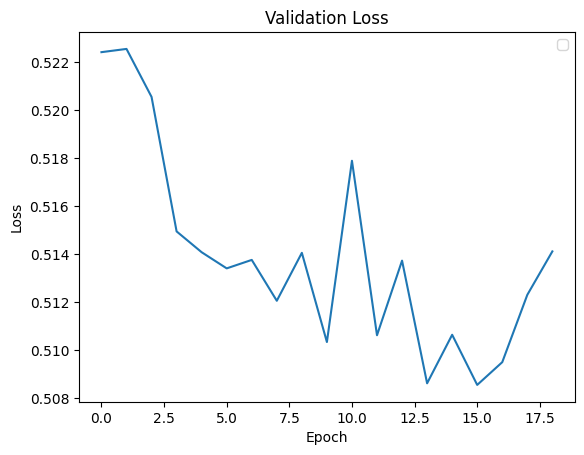

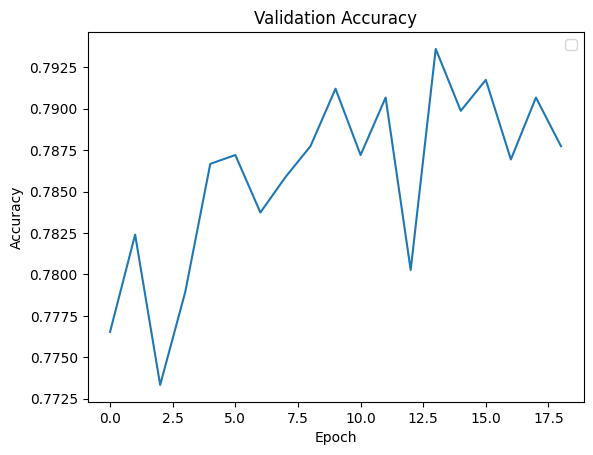

In [ ]:
train(model=model, X_train_tensor=X_train_tensor, y_train_tensor=y_train_tensor, num_epochs=50, loss_fn=loss_fn, optimizer=optimizer)

# III. Evaluate the model

In [ ]:
def test(model, X_test_tensor, y_test_tensor, loss_fn):
  model.eval()
  y_pred = model(X_test_tensor)
  loss = loss_fn(y_pred, y_test_tensor).item()

  y_pred_labels = torch.argmax(y_pred, dim=1)
  accuracy = accuracy_score(y_pred_labels.cpu().detach().numpy().flatten(), y_test_tensor.cpu().detach().numpy().flatten())
  return loss, accuracy

In [ ]:
test_loss, test_accuracy = test(model, X_test_tensor, y_test_tensor, loss_fn)
print('Test loss: {}'.format(test_loss))
print('Test accuracy: {}'.format(test_accuracy))

Test loss: 0.5203831195831299
Test accuracy: 0.7792207792207793


# IV. Save the Model

In [ ]:
# Save the model
torch.save(model.state_dict(), "model.pth")